# Getting colors for plotting and evaluating clustering



In [1]:
# Baked-in within python modules
from collections import defaultdict

# Alphabetical order for nonstandard python modules is conventional
# We're doing "import superlongname as abbrev" for our laziness - this way we don't have to type out the whole thing each time.

# Python plotting library
import matplotlib as mpl
import matplotlib.pyplot as plt

# Numerical python library (pronounced "num-pie")
import numpy as np

# Dataframes in Python
import pandas as pd

# T-test of independent samples
from scipy.stats import ttest_ind

# Statistical plotting library we'll use
import seaborn as sns
sns.set(style='whitegrid')

# Matrix decomposition
from sklearn.decomposition import PCA, FastICA

# Manifold learning
from sklearn.manifold import MDS, TSNE

# Clustering
from sklearn.cluster import KMeans, MiniBatchKMeans

# Plotting dendrograms
from scipy.cluster import hierarchy

# This is necessary to show the plotted figures inside the notebook -- "inline" with the notebook cells
%matplotlib inline

In [2]:
macaulay2016_expression = pd.read_csv('../data/macaulay2016/gene_expression_s.csv', index_col=0)


# Set maximum columns to display as 50 because the dataframe has 49 columns
pd.options.display.max_columns = 50

macaulay2016_metadata = pd.read_csv('../data/macaulay2016/sample_info_qc.csv', index_col=0)
# Add column for gfp
macaulay2016_metadata['gfp_color'] = ['#31a354' if c == 'HIGH' else '#e5f5e0' for c in macaulay2016_metadata['condition']]

# Necessary step for converting the parsed cluster color to be usable with matplotlib
macaulay2016_metadata['cluster_color'] = macaulay2016_metadata['cluster_color'].map(eval)

# --- Filter macaulay2016 data --- #
ensembl_genes = [x for x in macaulay2016_expression.index if x.startswith('ENS')]
cells_pass_qc = macaulay2016_metadata["Pass QC"].index[macaulay2016_metadata["Pass QC"]]

macaulay2016_expression_filtered = macaulay2016_expression.loc[ensembl_genes, cells_pass_qc]

# Recalculate TPM
macaulay2016_expression_filtered = 1e6 * macaulay2016_expression_filtered / macaulay2016_expression_filtered.sum()

# Transpose so it's machine learning format
macaulay2016_expression_filtered = macaulay2016_expression_filtered.T

# Take only "expressed genes" with expression greater than 1 in at least 3 cells
mask = (macaulay2016_expression_filtered > 1).sum() >= 3
macaulay2016_expression_filtered = macaulay2016_expression_filtered.loc[:, mask]
print('macaulay2016_expression_filtered.shape', macaulay2016_expression_filtered.shape)

# Add 1 and log10
macaulay2016_expression_log10 = np.log10(macaulay2016_expression_filtered + 1)

# Macaulay2016 plotting colors
macaulay2016_gfp_colors = macaulay2016_metadata.loc[macaulay2016_expression_log10.index, 'gfp_color']

# Get cluster colors from the paper
macaulay2016_cluster_colors_from_paper = macaulay2016_metadata.loc[macaulay2016_expression_log10.index, 'cluster_color']
macaulay2016_clusters_from_paper = macaulay2016_metadata.loc[macaulay2016_expression_log10.index, 'cluster']
macaulay2016_cluster_to_color_from_paper = dict(zip(macaulay2016_clusters_from_paper, macaulay2016_cluster_colors_from_paper))

macaulay2016_expression_filtered.shape (363, 20672)


## Clarification of hierarchical clustering goals

Use hierarchical clustering on either PCA or ICA to assign clusters to the Macaulay data and plot the PCA (or ICA) plot with the reduced clusters. **Are you able to recover the original clusters?** Use as many code cells as you need.

To clarify, the full steps for evaluating your hierarchical clustering on the Macaulay2016 dataset are:

1. Perform dimensionality reduction
2. Cluster the reduced data
3. Cut the dendrogram from the clustered data
4. Get the cluster colors and assignments
5. Re-plot the data with the sample colors
6. See how your clusters match with the Macaulay dataset

## How to get any number of colors for your data

In [3]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(macaulay2016_expression_log10)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [4]:
macaulay2016_smusher = PCA(n_components=2)
macaulay2016_smushed = pd.DataFrame(
    macaulay2016_smusher.fit_transform(macaulay2016_expression_log10),
    index=macaulay2016_expression_log10.index)

In [5]:
macaulay2016_kmeans_centroids = pd.DataFrame(macaulay2016_smusher.transform(
    kmeans.cluster_centers_))
macaulay2016_kmeans_centroids

,0,1
0,19.885299,-6.250915
1,-7.834866,12.098113
2,8.832527,5.389731
3,-29.646426,8.263945
4,-44.780920,-15.405350
5,-25.421757,13.124440


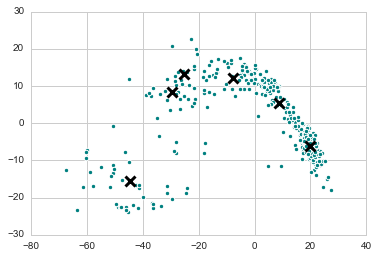

In [6]:
fig, ax = plt.subplots()

ax.scatter(macaulay2016_smushed[0], macaulay2016_smushed[1], color="Teal", 
           linewidth=1, edgecolor='white')
ax.scatter(macaulay2016_kmeans_centroids[0], macaulay2016_kmeans_centroids[1], 
            color='k', marker='x', s=100, linewidth=3)

In [7]:
kmeans.predict(macaulay2016_expression_log10)

array([5, 1, 4, 1, 1, 1, 4, 1, 1, 4, 3, 1, 4, 1, 3, 1, 2, 4, 4, 1, 3, 2, 3,
       2, 4, 1, 2, 2, 1, 1, 1, 2, 2, 5, 2, 1, 3, 2, 3, 1, 1, 2, 4, 2, 1, 1,
       2, 4, 1, 1, 4, 2, 1, 4, 1, 2, 4, 4, 1, 1, 3, 2, 1, 3, 3, 1, 2, 2, 1,
       4, 4, 2, 1, 3, 1, 1, 2, 2, 4, 4, 3, 4, 3, 2, 2, 1, 2, 3, 1, 2, 4, 4,
       2, 4, 4, 3, 1, 1, 2, 1, 2, 1, 1, 4, 2, 4, 2, 1, 1, 4, 1, 1, 2, 1, 2,
       4, 2, 1, 1, 1, 1, 4, 2, 4, 3, 2, 1, 4, 2, 2, 2, 3, 5, 5, 2, 3, 4, 4,
       1, 5, 1, 4, 1, 2, 2, 4, 5, 2, 2, 4, 1, 1, 2, 1, 5, 1, 3, 1, 1, 2, 1,
       2, 1, 2, 3, 4, 1, 1, 2, 1, 1, 4, 4, 4, 3, 4, 1, 1, 1, 4, 1, 4, 4, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 5,
       0, 0, 5, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 0, 0,
       0, 0,

[(0.89411765336990356, 0.10196078568696976, 0.1098039224743836),
 (0.21602460800432688, 0.49487120380588578, 0.71987698697576341),
 (0.30426760128900115, 0.68329106055054012, 0.29293349969620797),
 (0.60083047361934894, 0.30814303335021531, 0.63169552298153153),
 (1.0, 0.50591311045721454, 0.0031372549487094226),
 (0.99315647868549106, 0.98700499826786559, 0.19915417450315831),
 (0.65845446095747096, 0.34122261685483596, 0.17079585352364723),
 (0.95850826852461857, 0.50846600392285535, 0.7449288887136124),
 (0.60000002384185791, 0.60000002384185791, 0.60000002384185791)]

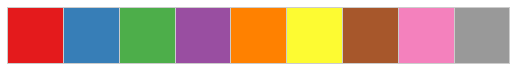

In [8]:
sns.choose_colorbrewer_palette('qualitative')

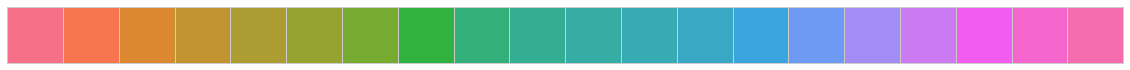

In [9]:
husl_palette = sns.color_palette('husl', n_colors=20)
sns.palplot(husl_palette)

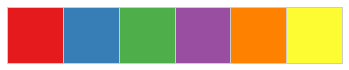

In [10]:
kmeans_palette = sns.color_palette('Set1', n_colors=6)
sns.palplot(kmeans_palette)

In [11]:
labels = pd.Series(kmeans.predict(macaulay2016_expression_log10), 
                   index=macaulay2016_expression_log10.index)
colors = [kmeans_palette[i] for i in labels]
print(len(labels))
print(len(colors))

363
363


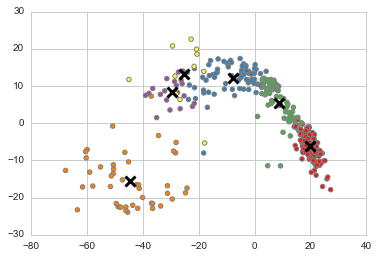

In [12]:
fig, ax = plt.subplots()

ax.scatter(macaulay2016_smushed[0], macaulay2016_smushed[1], color=colors, 
           linewidth=1, edgecolor='grey')
ax.scatter(macaulay2016_kmeans_centroids[0], macaulay2016_kmeans_centroids[1], 
            color='k', marker='x', s=100, linewidth=3)

### Exercise 1

Change the number of clusters to 20 and use the `"husl"` palette for coloring

## Evaluating clustering

How do we evaluate the clusters that we found versus the clusters from the paper?

In [13]:
# Get the unique names of the original Macaulay2016 clusters
cluster_names = macaulay2016_metadata.cluster.unique()
# Sort them in alphabetical order so that they're in the order we want
cluster_names.sort()

# Map the cluster name to an integer number
cluster_name_to_integer = dict(zip(cluster_names, range(len(cluster_names))))

paper_cluster_integers = macaulay2016_metadata.cluster.map(cluster_name_to_integer)
paper_cluster_integers.head()

Well
DIM_1_A1     2
DIM_1_A10    3
DIM_1_A11    2
DIM_1_A12    2
DIM_1_A2     3
Name: cluster, dtype: int64

In [14]:
macaulay2016_palette = [macaulay2016_cluster_to_color_from_paper[x] for x in cluster_names]

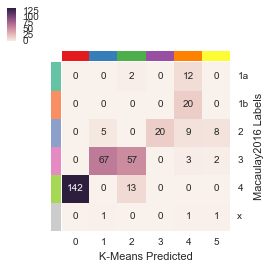

In [15]:
from sklearn.metrics import confusion_matrix

confusion = pd.DataFrame(confusion_matrix(paper_cluster_integers, labels), 
                         index=cluster_names)
confusion.index.name = 'Macaulay2016 Labels'
confusion.columns.name = 'K-Means Predicted'

confusiongrid = sns.clustermap(confusion, annot=True, fmt='d', figsize=(4, 4),
               col_cluster=False, row_cluster=False, 
               row_colors=macaulay2016_palette, col_colors=kmeans_palette)

# rotate the ylabels to be horizontal instead of vertical
plt.setp(confusiongrid.ax_heatmap.get_yticklabels(), rotation=0);

### Evaluating clustering: Rand score

The [Rand index](https://en.wikipedia.org/wiki/Rand_index) is a numeric value indicating 

In [16]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score([0, 0, 1, 1], [0, 0, 1, 1])


1.0

In [17]:
adjusted_rand_score([0, 0, 1, 1], [1, 1, 0, 0])

1.0


### Exercise 2

Try your own labels and values to see the rand score. You can try as many samples or classes as you want

In [18]:
# adjusted_rand_score([XXXX], [XXXX])

### Exercise 3

Get the Rand score of your clustering

In [19]:
# YOUR CODE HERE